--------------------------------------------------------------------------------

------------------------------------------------------------------------------


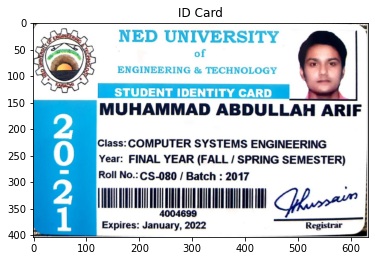

------------------------------------------------------------------------------

----------------------------------------------------------------------------
------------------------------------------------------------------------------

----------------------------------------------------------------------------
DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])
--------------------------------------------------------------------------------

------------------------------------------------------------------------------


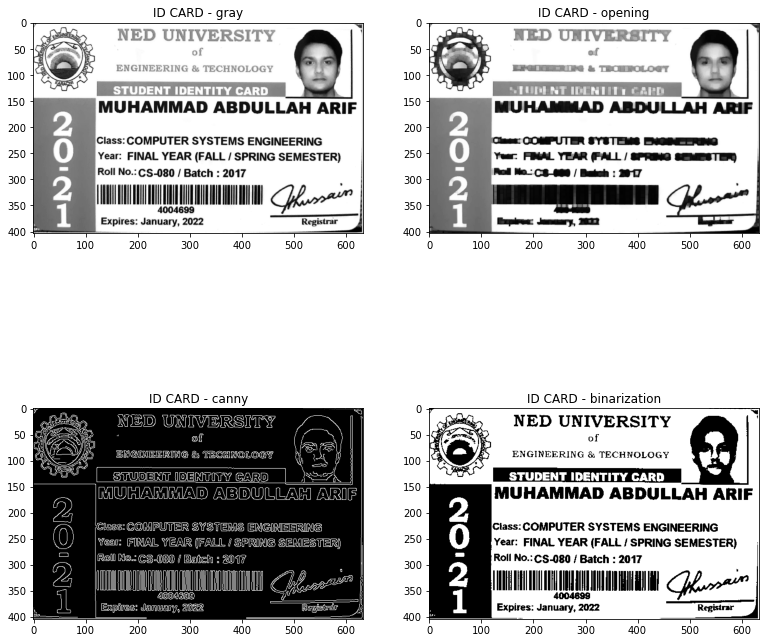

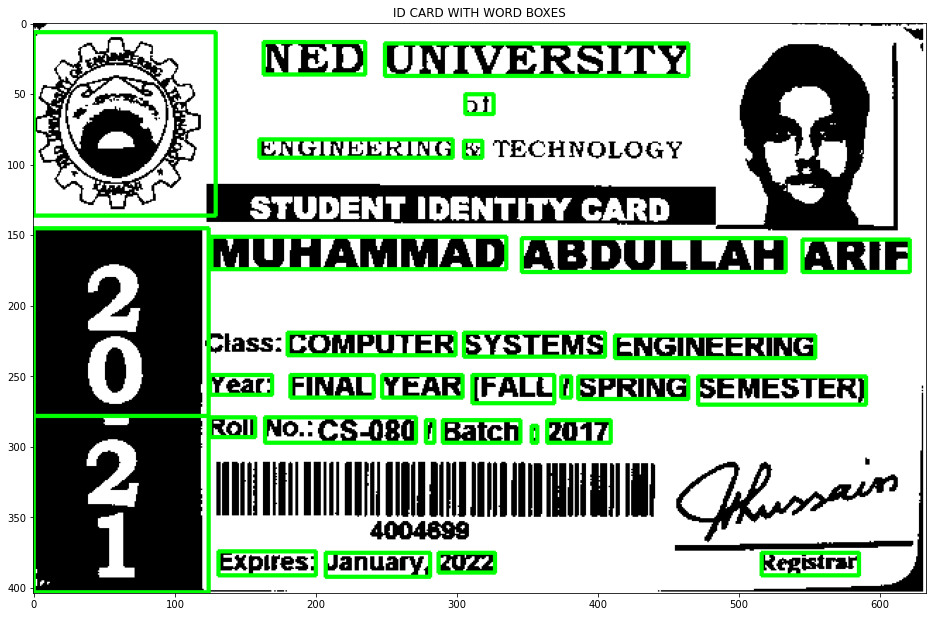

-------------------------------------------------------------------------------

-----------------------------------------------------------------------------


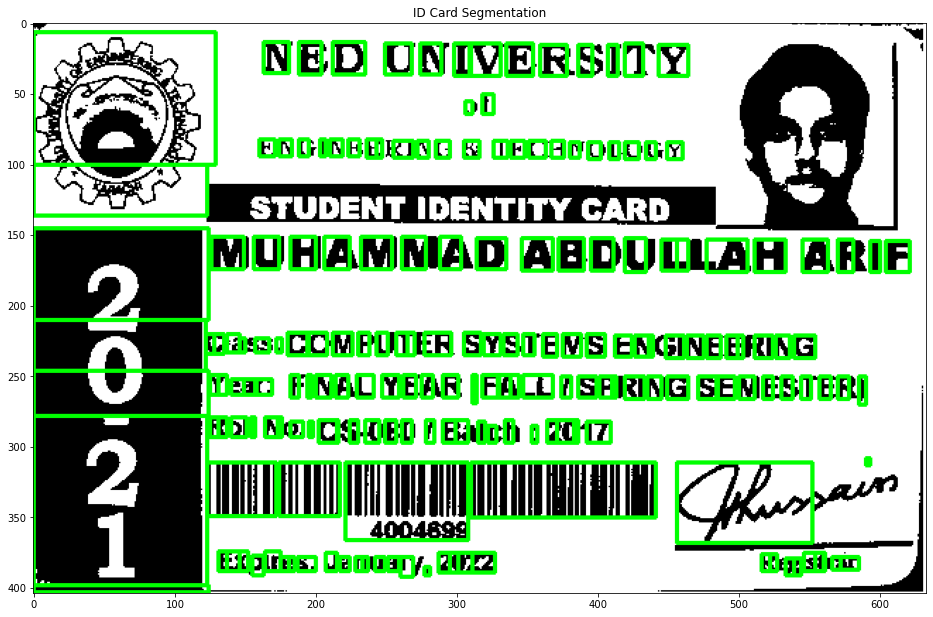

------------------------------------------------------------------------------

----------------------------------------------------------------------------
angle:  0
script:  Latin
------------------------------------------------------------------------------

----------------------------------------------------------------------------
OCR OUTPUT --> ID Card
------------------------------------------------------------------------------
NED UNIVERSITY

of
ENGINEERING & TECHNOLOGY

MUHAMMAD ABDULLAH ARIF

  
   
  

Class: COMPUTER SYSTEMS ENGINEERING
Year: FINAL YEAR (FALL / SPRING SEMESTER)
Roll No::C$-080 / Batch : 2017

UTU. *%

Expires: January, 2022 Registrar




In [31]:
#dependencies
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

#directories definition
pytesseract.pytesseract.tesseract_cmd = 'D:/Tesseract-OCR/tesseract.exe'
tessdata_dir_config = '--tessdata-dir "D:\\Tesseract-OCR\\tessdata"'
IMG_DIR = 'images/'

##preprocessing functions
# get grayscale image
def get_grayscale(image):
    #will convert colored image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    #compute the median of all the pixels
    return cv2.medianBlur(image,5)

#A set of operations that process images based on shapes.
#Morphological operations apply a structuring element to an input image and generate an output image.
#dilation
def dilate(image):
    #Generate a 5x5 matrix for convolution.
    kernel = np.ones((5,5),np.uint8)
    #increases the size of foreground/noise removal
    #convolute the image with kernel created above
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    #Generate a 5x5 matrix for convolution.
    kernel = np.ones((5,5),np.uint8)
    #A pixel in the original image (either 1 or 0) will be considered 1 
    #only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    #5x5 because we want gaussian blur which is needed for canny detection
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    #performs edge detection
    #minVal = 100, maxVal = 200
    return cv2.Canny(image, 100, 200)

#thresholding
def thresholding(image):
    #performs binarization on image
    #here image should be a grayscale image
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#skew correction
def deskew(image):
    #Will use to stack 1D array into 2D array
    coords = np.column_stack(np.where(image > 0))
    #generates a minimum bounding rectangle
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    #shape consists of (height, width, other dimensions)
    #we are taking only height and width by slicing
    (h, w) = image.shape[:2]
    #calculating center from height and width
    center = (w // 2, h // 2)
    #create rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    #rotatte the image using original image, rotation matrix, interpolation, border creation
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 
print('--------------------------------------------------------------------------------')
print('\n------------------------------------------------------------------------------')
# Plot original image
image = cv2.imread(IMG_DIR + 'IDCard.PNG')
origimage = image
#splitting image into r,g,b components
b,g,r = cv2.split(image)
#merging them again to form image
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('ID Card')
plt.show()

# Preprocess image 
gray = get_grayscale(image)
opening = opening(gray)
canny = canny(gray)
thresh = thresholding(gray)
cv2.imwrite(IMG_DIR + 'binarized.PNG', thresh)
images = {'gray': gray,  
          'opening': opening, 
          'canny': canny,
         'binarization': thresh}
print('------------------------------------------------------------------------------')
print('\n----------------------------------------------------------------------------')
# Plot images after preprocessing
#plot figure of specified size
fig = plt.figure(figsize=(13,13))
ax = []
#creating a matrix for subplotting different preprocessing outputs
rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('ID CARD - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')
print('------------------------------------------------------------------------------')
print('\n----------------------------------------------------------------------------')

# Plot original image

#image = cv2.imread(IMG_DIR + 'image.PNG')
#b,g,r = cv2.split(image)
#rgb_img = cv2.merge([r,g,b])

#plt.figure(figsize=(16,12))
#plt.imshow(rgb_img)
#plt.title(' IMAGE')
#plt.show()

# Plot word boxes on image using pytesseract.image_to_data() function
image = cv2.imread(IMG_DIR + 'binarized.PNG')
#Returns result containing box boundaries, confidences, and other information. 
d = pytesseract.image_to_data(image, output_type=Output.DICT, lang='eng', config=tessdata_dir_config)
print('DATA KEYS: \n', d.keys())
#isme text daalo
n_boxes = len(d['text'])
#hrr text me se choose kro
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        #cv2.rectangle(image, start_point, end_point, color, thickness)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
print('--------------------------------------------------------------------------------')
print('\n------------------------------------------------------------------------------')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('ID CARD WITH WORD BOXES')
plt.show()

# Plot character boxes on image using pytesseract.image_to_boxes() function
image = cv2.imread(IMG_DIR + 'binarized.PNG')
#taking out height width and center
h, w, c = image.shape
#initializing bounding boxes on blobs
boxes = pytesseract.image_to_boxes(image, lang='eng', config=tessdata_dir_config)
#
for b in boxes.splitlines():
    #split by single space
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
print('-------------------------------------------------------------------------------')
print('\n-----------------------------------------------------------------------------')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('ID Card Segmentation')
plt.show()

# Get angle and script
osd = pytesseract.image_to_osd(origimage, lang='eng', config=tessdata_dir_config)
angle = re.search('(?<=Rotate: )\d+', osd).group(0)
script = re.search('(?<=Script: )\w+', osd).group(0)
image = cv2.imread(IMG_DIR + 'binarized.PNG')
print('------------------------------------------------------------------------------')
print('\n----------------------------------------------------------------------------')
print("angle: ", angle)
print("script: ", script)
# Get OCR output using Pytesseract
custom_config = r'--oem 3 --psm 6'
print('------------------------------------------------------------------------------')
print('\n----------------------------------------------------------------------------')
print('OCR OUTPUT --> ID Card')
print('------------------------------------------------------------------------------')
print(pytesseract.image_to_string(image, lang='eng', config=tessdata_dir_config))
